# AUGMENTATION

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
download1 = drive.CreateFile({'id': '1flRHIQFRFo-ZKzJ595xx9AKy9FfyUukR'})
download1.GetContentFile('VOCtrainval_11-May-2012.tar')
print('part1')
# download2 = drive.CreateFile({'id': '1IJEwYacSiUW4eQVO5M2my_t354DFvEwy'})
# download2.GetContentFile('VOC2012test.tar')
print('part2')
download3 = drive.CreateFile({'id': '1c-2fvV-iM6Exsz50XPtF8pjN2LlfNhOz'})
download3.GetContentFile('VOCdevkit_18-May-2011.tar')
print('part3')
#https://drive.google.com/open?id=1flRHIQFRFo-ZKzJ595xx9AKy9FfyUukR
#https://drive.google.com/open?id=1IJEwYacSiUW4eQVO5M2my_t354DFvEwy
#https://drive.google.com/open?id=1c-2fvV-iM6Exsz50XPtF8pjN2LlfNhOz

part1
part2
part3


In [0]:
import tarfile
my_tar1 = tarfile.open('VOCtrainval_11-May-2012.tar')
my_tar1.extractall('./data') # specify which folder to extract to
# my_tar2 = tarfile.open('VOC2012test.tar')
# my_tar2.extractall('./data') # specify which folder to extract to
my_tar3 = tarfile.open('VOCdevkit_18-May-2011.tar')
my_tar3.extractall('./data') # specify which folder to extract to
my_tar1.close()
# my_tar2.close()
my_tar3.close()

In [5]:
ls

adc.json  gdrive/       VOCdevkit_18-May-2011.tar    xml2json.py
data/     sample_data/  VOCtrainval_11-May-2012.tar


In [6]:
!python xml2json.py ./data/VOCdevkit 2012

5717
5823
11540


In [0]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [0]:
import cv2
import numpy as np
import random
import json
import pandas as pd
from collections import namedtuple,defaultdict
import torch
import os
import sys
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [0]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
        if random.random() < self.p:
            img_center = img.shape[0] / 2
            img =  img[:,::-1,:]
            img = np.ascontiguousarray(img)

            bboxes[:, 0] += 2*(img_center - bboxes[:,0])
        return img, bboxes

class RandomContrast:
    def __init__(self, lower=0.5, upper=1.5, p=0.5):
        self.lower = lower
        self.upper = upper
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            alpha = random.uniform(self.lower, self.upper)
            img *= alpha
        return img

# DATA TRANSFORMER


In [0]:
ImageEntry = namedtuple("ImageEntry", ["filename", "width", "height",
                                       "classnames", "class_id",
                                       "bounding_boxes"
                                       ])


def load_pascal(json_path):
    json_data = json.load(open(json_path))

    images_df = pd.DataFrame(json_data["images"])
    anno_df = pd.DataFrame(json_data["annotations"])

    anno_df = anno_df[["image_id", "bbox", "category_id"]]
    anno_df = anno_df.rename(columns={"image_id": "id"})

    id_classname = {}
    for row in json_data["categories"]:
        id_classname[row["id"]] = row["name"]

    anno_df["classname"] = anno_df.apply(lambda x: id_classname[x["category_id"]], axis=1)
    df = anno_df.merge(images_df, on="id")

    grouped_data = []
    grouped = df.groupby("file_name")
    for name, group in grouped:
        val = ImageEntry(filename=name, width=group["width"].values[0], height=group["height"].values[0],
                         classnames=list(group["classname"].values), class_id=list(group["category_id"].values - 1),
                         bounding_boxes=list(group["bbox"].values))
        grouped_data.append(val)
    return id_classname, grouped_data


def rescale_bounding_boxes(data_list, target_size):
    """
    Rescaling the bounding boxes according to the new image size (target_size).
    """

    for i in range(len(data_list)):
        d = data_list[i]
        x_scale = target_size / d.width
        y_scale = target_size / d.height

        new_boxes = []
        for box in d.bounding_boxes:
            (x, y, d_x, d_y) = box

            x = int(round(x * x_scale))
            y = int(round(y * y_scale))
            d_x = int(round(d_x * x_scale))
            d_y = int(round(d_y * y_scale))

            new_boxes.append([x, y, d_x, d_y])

        data_list[i] = data_list[i]._replace(bounding_boxes=new_boxes)
    return data_list


def convert_to_center(data_list):
    """
    Converting [bx, by, w, h] to [cx, cy, w, h].
    """

    for i in range(len(data_list)):
        d = data_list[i]

        new_boxes = []
        for box in d.bounding_boxes:
            cx = box[0] + box[2]/2
            cy = box[1] + box[3]/2
            new_boxes.append([cx, cy, box[2], box[3]])
        data_list[i] = data_list[i]._replace(bounding_boxes=new_boxes)
    return data_list


def invert_transformation(bb_hat, anchors):
    """
    Invert the transform from "loc_transformation".
    """

    return torch.stack([anchors[:, 0] + bb_hat[:, 0] * anchors[:, 2],
                        anchors[:, 1] + bb_hat[:, 1] * anchors[:, 3],
                        anchors[:, 2] * torch.exp(bb_hat[:, 2]),
                        anchors[:, 3] * torch.exp(bb_hat[:, 3])
                        ], dim=1)

# DISPLAY(RECTANGLES,IMAGES,GRIDS,TEXTS)

In [0]:
def read_img(img_str, target_size):
    img = cv2.imread(img_str, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size, target_size))
    return img


def draw_boxes(img, boxes):
    for box in boxes:
        cv2.rectangle(img, (int(box[0] - box[2]/2), int(box[1] - box[3]/2)),
                      (int(box[0] + box[2]/2), int(box[1] + box[3]/2)),
                      (0, 0, 255), 2)

    return img


def draw_grid(img, pixel_step):
    x = pixel_step
    y = pixel_step

    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=(255, 255, 255))
        x += pixel_step

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=(255, 255, 255))
        y += pixel_step

    return img


def draw_text(img, texts, locations):
    for text, loc in zip(texts, locations):
        cv2.putText(img, text, (int(loc[0]), int(loc[1])), cv2.FONT_HERSHEY_COMPLEX,
                    0.5, (255, 0, 0), 1)
    return img

# EVALUATION(MEAN AVERAGE PRECISION),JACCARD INDEX,NON MAX SUPPRESSION(NMS)

In [0]:
PredBoundingBox = namedtuple("PredBoundingBox", ["probability", "class_id",
                                                 "classname", "bounding_box"
                                                 ])


class MAP:
    def __init__(self, model, dataset, jaccard_threshold, anchors):
        self.jaccard_threshold = jaccard_threshold
        self.model = model
        self.eps = np.finfo(np.float32).eps
        self.anchors = anchors
        self.dataset = dataset

    @staticmethod
    def voc_ap(rec, prec):
        """Compute VOC AP given precision and recall with the VOC-07 11-point method."""

        ap = 0.0
        for t in np.arange(0.0, 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0.0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.0
        return ap

    def __call__(self):
        self.model.eval()
        aps = defaultdict(list)

        for i in range(len(self.dataset)):
            (x, bb_true, class_true) = self.dataset[i]
            class_true = class_true.squeeze(0) - 1 # -1 to convert it from 1-21 to 0-20

            x = x[None, :, :, :]
            class_hat, bb_hat = self.model(x)
            class_hat = class_hat[0, :, 1:].sigmoid()

            bb_hat = invert_transformation(bb_hat.squeeze(0), self.anchors)
            jacard_values = jaccard(bb_hat.squeeze(0), bb_true.squeeze(0))

            for j in range(len(class_true)):
                overlap = (jacard_values[:, j] > self.jaccard_threshold).nonzero()
                class_true_j = int(class_true[j].detach().cpu().numpy())

                if len(overlap) > 0:
                    class_hat_j = class_hat[overlap[:,0], :]
                    prob, class_id = class_hat_j.max(1)
                    prob, sort_index = torch.sort(prob, descending=True)
                    class_id = class_id[sort_index].detach().cpu().numpy()

                    tp = np.zeros_like(class_id)
                    fp = np.zeros_like(class_id)

                    found = False
                    for d in range(len(class_id)):
                        if found or class_id[d] != class_true[j]:
                            fp[d] = 1.0
                        else:
                            tp[d] = 1.0
                            found = True

                    fp = np.cumsum(fp)
                    tp = np.cumsum(tp)

                    rec = tp
                    prec = tp / np.maximum(tp + fp, self.eps)

                    temp_ap = MAP.voc_ap(rec, prec)
                    aps[class_true_j].append(temp_ap)
                else:
                    aps[class_true_j].append(0)

        res_list = []
        for _, list_value in aps.items():
            res_list.append(sum(list_value) / len(list_value))

        return res_list, sum(res_list) / len(res_list)


def center_2_hw(box: torch.Tensor) -> float:
    """
    Converting (cx, cy, w, h) to (x1, y1, x2, y2)
    """

    return torch.cat(
        [box[:, 0, None] - box[:, 2, None]/2,
         box[:, 1, None] - box[:, 3, None]/2,
         box[:, 0, None] + box[:, 2, None]/2,
         box[:, 1, None] + box[:, 3, None]/2
         ], dim=1)


def intersect(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    # Coverting (cx, cy, w, h) to (x1, y1, x2, y2) since its easier to extract min/max coordinates
    temp_box_a, temp_box_b = center_2_hw(box_a), center_2_hw(box_b)

    max_xy = torch.min(temp_box_a[:, None, 2:], temp_box_b[None, :, 2:])
    min_xy = torch.max(temp_box_a[:, None, :2], temp_box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def box_area(box: torch.Tensor) -> float:
    return box[:, 2] * box[:, 3]


def jaccard(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    intersection = intersect(box_a, box_b)
    union = box_area(box_a).unsqueeze(1) + box_area(box_b).unsqueeze(0) - intersection
    return intersection / union


def non_max_suppression(bounding_boxes: list, iou_threshold: float = 0.5) -> list:
    filtered_bb = []

    while len(bounding_boxes) != 0:
        best_bb = bounding_boxes.pop(0)
        filtered_bb.append(best_bb)

        remove_items = []
        for bb in bounding_boxes:
            iou = jaccard(torch.tensor(best_bb.bounding_box).unsqueeze(0), 
                          torch.tensor(bb.bounding_box).unsqueeze(0))

            if iou > iou_threshold:
                remove_items.append(bb)
        bounding_boxes = [bb for bb in bounding_boxes if bb not in remove_items]
    return filtered_bb

In [13]:
target_size = 224
seed = 42
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('gpu')  # you can continue going on here, like cuda:1 cuda:2....etc. 
else:
    device = torch.device("cpu")

gpu


In [0]:
data_list = []
id_cat, temp_list = load_pascal(train_json_path)
data_list += temp_list
_, temp_list =load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [0]:
data_list = rescale_bounding_boxes(data_list, target_size)
data_list = convert_to_center(data_list)

In [16]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['train', 'person', 'person'], class_id=[18, 14, 14], bounding_boxes=[[112.0, 92.5, 224, 185], [80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81]])

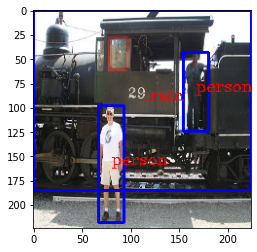

In [17]:
img_str = IMG_PATH + example.filename
img = read_img(img_str, target_size)

img = draw_boxes(img, example.bounding_boxes)
img = draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [0]:
anchor_grid = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [0]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [0]:

anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [0]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [0]:
batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [0]:
class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x        

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)), 
                self.flatten_conv(self.conv_2(x))]

class Model(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([
            StandardConv(512, 256, p[1], stride=1),
            StandardConv(256, 256, p[1], stride=1),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1])
        ])

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)

        x = self.std_conv[0](x)
        x = self.std_conv[1](x)
        output_class_0, output_bb_0 = self.out_conv[0](x)

        x = self.std_conv[2](x)
        output_class_1, output_bb_1 = self.out_conv[1](x)

        x = self.std_conv[3](x)
        output_class_2, output_bb_2 = self.out_conv[2](x)

        x = self.std_conv[4](x)
        output_class_3, output_bb_3 = self.out_conv[3](x)

        # Class, bounding box
        return [torch.cat([output_class_0, output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_0, output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

In [0]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)

    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [0]:
class SSDLoss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [0]:
loc_factor = 10.0
jaccard_overlap = 0.6

loss = SSDLoss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

In [28]:
p = [0.2, 0.5]

torch.manual_seed(seed)
model = Model(num_boxes=num_boxes, p=p).to(device)
model.change_freezing(False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
n_epochs = 40
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [0]:
jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

In [31]:
torch.manual_seed(seed)
random.seed(seed)
for epoch in range(n_epochs+1):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()
        train_class_loss += batch_class.detach().cpu().numpy()
        train_loc_loss += batch_loc.detach().cpu().numpy()

    train_loss =  np.round(train_loss / len(train_loader), 6)
    train_loc_loss =  np.round(train_loc_loss / len(train_loader), 6)
    train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(val_loader):
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        val_loss += batch_loss.detach().cpu().numpy()
        val_loc_loss += batch_loc.detach().cpu().numpy()
        val_class_loss += batch_class.detach().cpu().numpy()

    val_loss = np.round(val_loss / len(val_loader), 6)
    val_loc_loss = np.round(val_loc_loss / len(val_loader), 6)
    val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if epoch % 5 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Train loc loss: {train_loc_loss}")
        print(f"Train class loss: {train_class_loss}")
        print(f"Val loss: {val_loss}")
        print(f"Val loc loss: {val_loc_loss}")
        print(f"Val class loss: {val_class_loss}")
        print(f"Val mAP: {mAP}")


----- Epoch 0 -----
Train loss: 43.933917
Train loc loss: 0.306102
Train class loss: 40.872897
Val loss: 8.239166
Val loc loss: 0.256356
Val class loss: 5.675607
Val mAP: 0.080615
----- Epoch 5 -----
Train loss: 6.36914
Train loc loss: 0.197299
Train class loss: 4.39615
Val loss: 6.859099
Val loc loss: 0.227537
Val class loss: 4.583731
Val mAP: 0.183823
----- Epoch 10 -----
Train loss: 5.837213
Train loc loss: 0.179169
Train class loss: 4.045519
Val loss: 6.456127
Val loc loss: 0.234321
Val class loss: 4.112921
Val mAP: 0.249772
----- Epoch 15 -----
Train loss: 5.452605
Train loc loss: 0.166795
Train class loss: 3.784653
Val loss: 6.073138
Val loc loss: 0.197979
Val class loss: 4.093347
Val mAP: 0.306633
----- Epoch 20 -----
Train loss: 5.200874
Train loc loss: 0.160639
Train class loss: 3.594482
Val loss: 5.846129
Val loc loss: 0.190529
Val class loss: 3.940844
Val mAP: 0.331237
----- Epoch 25 -----
Train loss: 5.026029
Train loc loss: 0.154157
Train class loss: 3.48446
Val loss: 5.77

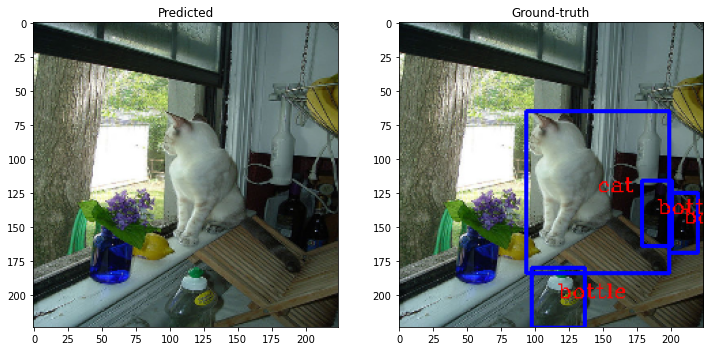

In [46]:
background_threshold = 0.5

i = 25
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)


# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []


output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]



output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)
filtered_bb = non_max_suppression(output_bb)
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file


f, axs = plt.subplots(1, 2, figsize=(12, 12))
img_pred = read_img(img_str, target_size)
img_pred = draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = read_img(img_str, target_size)
img_gt = draw_boxes(img_gt, example.bounding_boxes)
img_gt = draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()

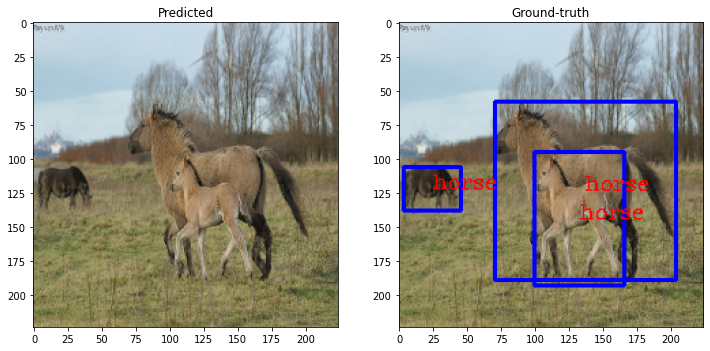

In [47]:
background_threshold = 0.5

i = 125
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)


# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []


output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]



output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)
filtered_bb = non_max_suppression(output_bb)
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file


f, axs = plt.subplots(1, 2, figsize=(12, 12))
img_pred = read_img(img_str, target_size)
img_pred = draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = read_img(img_str, target_size)
img_gt = draw_boxes(img_gt, example.bounding_boxes)
img_gt = draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()

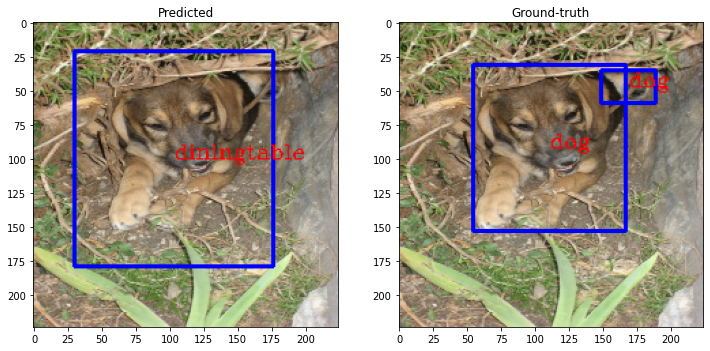

In [51]:
background_threshold = 0.5

i = 1112
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)


# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []


output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]



output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)
filtered_bb = non_max_suppression(output_bb)
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file


f, axs = plt.subplots(1, 2, figsize=(12, 12))
img_pred = read_img(img_str, target_size)
img_pred = draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = read_img(img_str, target_size)
img_gt = draw_boxes(img_gt, example.bounding_boxes)
img_gt = draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()

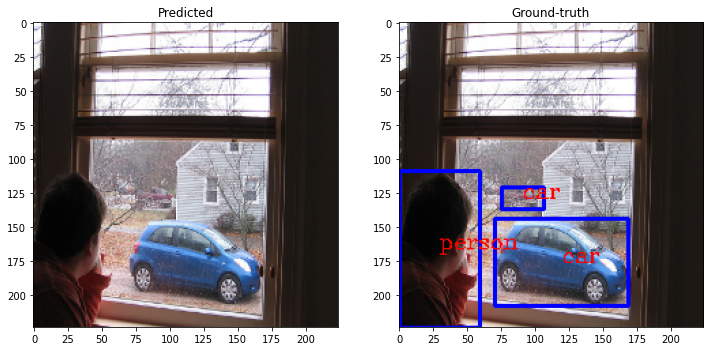

In [52]:
background_threshold = 0.5

i = 500
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)


# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []


output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]



output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)
filtered_bb = non_max_suppression(output_bb)
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file


f, axs = plt.subplots(1, 2, figsize=(12, 12))
img_pred = read_img(img_str, target_size)
img_pred = draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = read_img(img_str, target_size)
img_gt = draw_boxes(img_gt, example.bounding_boxes)
img_gt = draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()